The dataset has 5171 rows and 4 columns.
First five rows of the dataset:
   Unnamed: 0 label                                               text  \
0         605   ham  Subject: enron methanol ; meter # : 988291\r\n...   
1        2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...   
2        3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3        4685  spam  Subject: photoshop , windows , office . cheap ...   
4        2030   ham  Subject: re : indian springs\r\nthis deal is t...   

   label_num  
0          0  
1          0  
2          0  
3          1  
4          0  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
mem

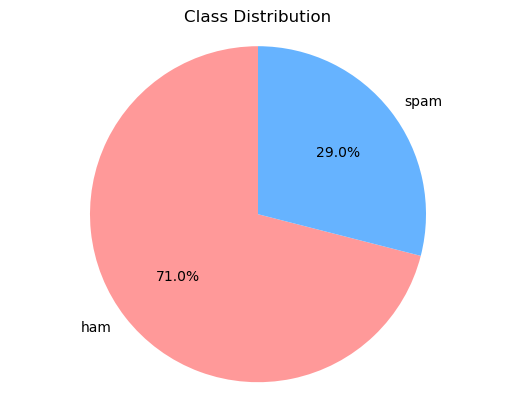

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.9871846321901524

Test Set Accuracy: 0.9903381642512077

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       742
           1       0.98      0.98      0.98       293

    accuracy                           0.99      1035
   macro avg       0.99      0.99      0.99      1035
weighted avg       0.99      0.99      0.99      1035



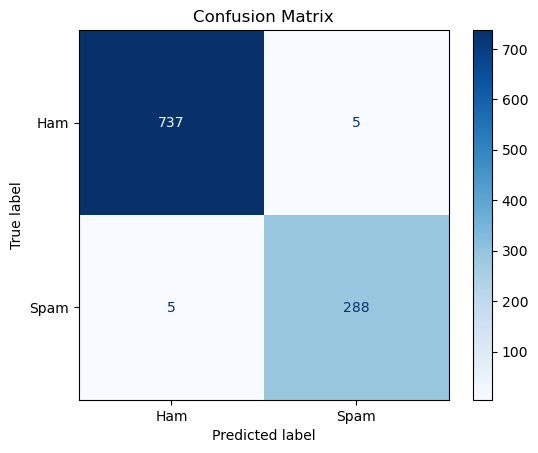


Model and vectorizer saved successfully!
Email: Meeting scheduled for tomorrow. Please check the agenda.
Prediction: Ham

Email: Congratulations! You've won a free vacation to Hawaii. Click here to claim!
Prediction: Spam

Email: Urgent: Your account has been compromised. Please reset your password immediately.
Prediction: Ham

Email: Join us for the team lunch tomorrow at noon in the cafeteria.
Prediction: Ham



In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string
import matplotlib.pyplot as plt

# Ensure nltk resources are downloaded
nltk.download('stopwords', quiet=True)

# Load the dataset
data = pd.read_csv('spam_ham_dataset.csv')  # Replace with your actual dataset path

# Display basic dataset information
print(f"The dataset has {data.shape[0]} rows and {data.shape[1]} columns.")
print("First five rows of the dataset:")
print(data.head())
print("\nDataset Info:")
print(data.info())
print("\nNull Values:\n", data.isnull().sum())
print(f"\nDuplicated values: {data.duplicated().sum()}")

# Preprocess the text column
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

def clean_text(text):
    """Preprocess text by removing punctuation, stopwords, and applying stemming."""
    text = ''.join([char for char in text if char not in string.punctuation])
    words = text.split()
    words = [stemmer.stem(word) for word in words if word.lower() not in stop_words]
    return ' '.join(words)

data['clean_text'] = data['text'].apply(clean_text)

# Display class distribution
label_counts = data['label'].value_counts()
print("\nClass Distribution:\n", label_counts)

# Visualize class distribution with a pie chart
labels = label_counts.index
sizes = label_counts.values
colors = ['#FF9999', '#66B3FF']  # Custom colors for the pie chart
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title("Class Distribution")
plt.axis('equal')
plt.show()

# Define features (X) and target (y)
X = data['clean_text']  # Features
y = data['label_num']  # Target (0 for ham, 1 for spam)

# Vectorize the text data
vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)
X = vectorizer.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel types
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'degree': [2, 3, 4],  # Degree of polynomial kernel
}

# Initialize the SVM model
svc = SVC()

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1,  # Use all available cores
)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Check the best parameters and best cross-validation score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Predict on the test set using the best model
y_pred = best_model.predict(X_test)

# Evaluate model performance on the test set
print("\nTest Set Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham", "Spam"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Save the trained model and vectorizer for future use
import pickle

with open('svm_model.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

with open('vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

print("\nModel and vectorizer saved successfully!")

# Function to classify new emails
def predict_email(input_email, model, vectorizer):
    """Classify a single email as Ham or Spam."""
    cleaned_email = clean_text(input_email)  # Clean the email
    vectorized_email = vectorizer.transform([cleaned_email])  # Vectorize the email
    prediction = model.predict(vectorized_email)  # Predict the label
    return "Ham" if prediction[0] == 0 else "Spam"

# Test the classification on new emails
test_emails = [
    "Meeting scheduled for tomorrow. Please check the agenda.",
    "Congratulations! You've won a free vacation to Hawaii. Click here to claim!",
    "Urgent: Your account has been compromised. Please reset your password immediately.",
    "Join us for the team lunch tomorrow at noon in the cafeteria."
]

for email in test_emails:
    result = predict_email(email, best_model, vectorizer)
    print(f"Email: {email}\nPrediction: {result}\n")
